📊 Dataset shape: (43590, 60), Labels: [17692 25898]

📈 Confusion Matrix:
[[2277 1262]
 [1433 2105]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.64      0.63      3539
         1.0       0.63      0.59      0.61      3538

    accuracy                           0.62      7077
   macro avg       0.62      0.62      0.62      7077
weighted avg       0.62      0.62      0.62      7077

🎯 ROC-AUC Score: 0.6724


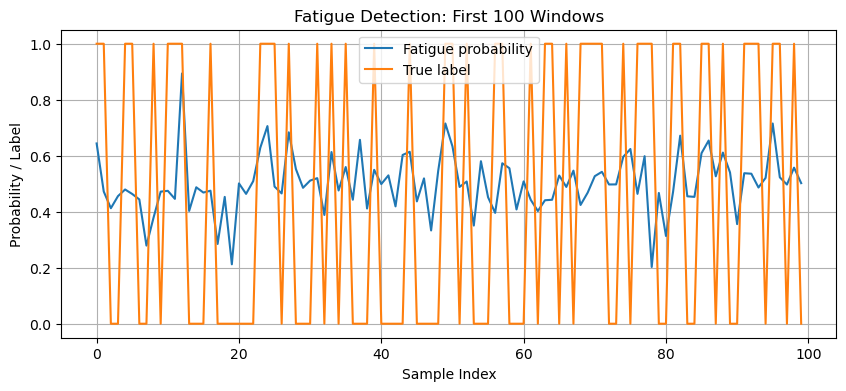

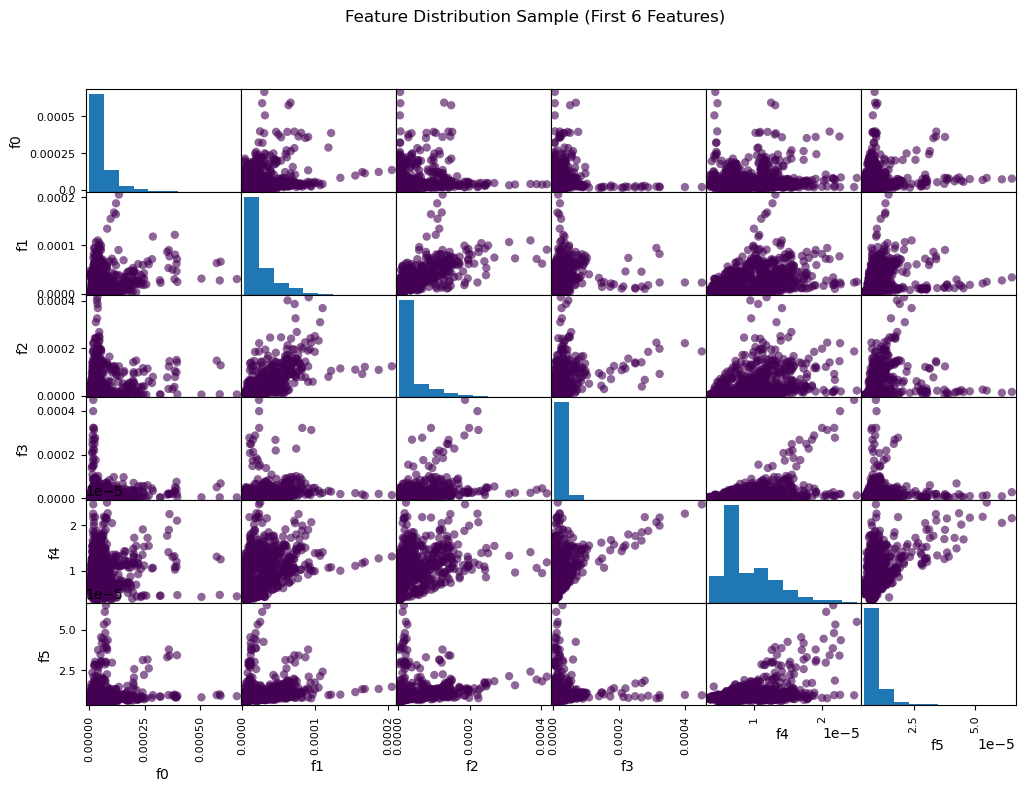

In [ ]:
import scipy.io
import mat73
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

window_size = 1000
step_size = 500
emg_key = 'emg'
restimulus_key = 'restimulus'
rerepetition_key = 'rerepetition'

def extract_features(emg_segment):
    rms = np.sqrt(np.mean(emg_segment**2, axis=0))
    mav = np.mean(np.abs(emg_segment), axis=0)
    wl = np.sum(np.abs(np.diff(emg_segment, axis=0)), axis=0)
    fft = np.abs(np.fft.rfft(emg_segment, axis=0))
    mean_freq = np.mean(fft, axis=0)
    median_freq = np.median(fft, axis=0)
    return np.concatenate([rms, mav, wl, mean_freq, median_freq])

def safe_loadmat(mat_path):
    try:
        return mat73.loadmat(mat_path)
    except:
        try:
            return scipy.io.loadmat(mat_path, variable_names=[emg_key, restimulus_key, rerepetition_key])
        except Exception as e:
            print(f"❌ Skipped {mat_path}: {e}")
            return None


X_all, y_all = [], []
mat_files = glob(r"C:\Users\kulwant dhillon\Downloads\DB2_s1\DB2_s1\*.mat")

for mat_path in mat_files:
    mat = safe_loadmat(mat_path)
    if mat is None:
        continue

    try:
        emg = mat[emg_key]
        restimulus = np.ravel(mat[restimulus_key])
        rerepetition = np.ravel(mat[rerepetition_key])
    except Exception as e:
        print(f"❌ Missing data in {mat_path}: {e}")
        continue

    for gesture in np.unique(restimulus):
        if gesture == 0:
            continue
        for rep in range(1, 6):
            indices = np.where((restimulus == gesture) & (rerepetition == rep))[0]
            if len(indices) < window_size:
                continue
            for start in range(0, len(indices) - window_size, step_size):
                segment = emg[indices[start:start + window_size], :]
                if segment.shape[0] < window_size:
                    continue
                features = extract_features(segment)
                X_all.append(features)
                y_all.append(0 if rep <= 2 else 1)

    del mat

X = np.array(X_all, dtype=np.float32)
y = np.array(y_all)
print(f"📊 Dataset shape: {X.shape}, Labels: {np.bincount(y)}")

X_f0 = X[y == 0]
X_f1 = X[y == 1]
X_f1_down, y_f1_down = resample(X_f1, y[y == 1], replace=False, n_samples=len(X_f0), random_state=42)
X_bal = np.vstack([X_f0, X_f1_down])
y_bal = np.concatenate([np.zeros(len(X_f0)), np.ones(len(X_f0))])

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, stratify=y_bal, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=20)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

clf = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("\n📈 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"🎯 ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

plt.figure(figsize=(10, 4))
plt.plot(y_prob[:100], label='Fatigue probability')
plt.plot(y_test[:100], label='True label')
plt.title("Fatigue Detection: First 100 Windows")
plt.xlabel("Sample Index")
plt.ylabel("Probability / Label")
plt.legend()
plt.grid()
plt.show()

df = pd.DataFrame(X_bal[:1000], columns=[f'f{i}' for i in range(X.shape[1])])
df['label'] = y_bal[:1000]
pd.plotting.scatter_matrix(df.iloc[:, :6], c=df['label'], figsize=(12, 8), marker='o', alpha=0.6)
plt.suptitle("Feature Distribution Sample (First 6 Features)")
plt.show()
